***Importing libraries and reading dataset***

In [1]:
import pandas as pd          
import numpy as np          
import matplotlib.pyplot as plt  
from datetime import datetime   
from pandas import Series        
%matplotlib inline
import warnings                   
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv("C:\\Users\\aayus\\Downloads\\Train_SU63ISt.csv")
test=pd.read_csv("C:\\Users\\aayus\\Downloads\\Test_0qrQsBZ.csv")

In [3]:
train_original=train.copy()
test_original=test.copy()

In [4]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [5]:
train.columns,test.columns

(Index(['ID', 'Datetime', 'Count'], dtype='object'),
 Index(['ID', 'Datetime'], dtype='object'))

In [6]:
train.dtypes, test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [7]:
train.shape, test.shape

((18288, 3), (5112, 2))

In [8]:
#converting to datetime format
train['Datetime'] = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
test['Datetime'] = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test_original['Datetime'] = pd.to_datetime(test_original.Datetime,format='%d-%m-%Y %H:%M')
train_original['Datetime'] = pd.to_datetime(train_original.Datetime,format='%d-%m-%Y %H:%M')

*extracting year, month, day,hour,dayofweek from datetime*

In [9]:
for i in (train, test, test_original, train_original):
    i['year']=i.Datetime.dt.year 
    i['month']=i.Datetime.dt.month 
    i['day']=i.Datetime.dt.day
    i['Hour']=i.Datetime.dt.hour 

In [10]:
train['day of week']=train['Datetime'].dt.dayofweek
temp = train['Datetime']

In [11]:
#assigning for weekend 1 and otherwise 0

In [12]:
def applyer(row):
    if row.dayofweek == 5 or row.dayofweek == 6:
        return 1
    else:
        return 0

temp2 = train['Datetime'].apply(applyer)
train['weekend']=temp2

**Plotting timeseries**

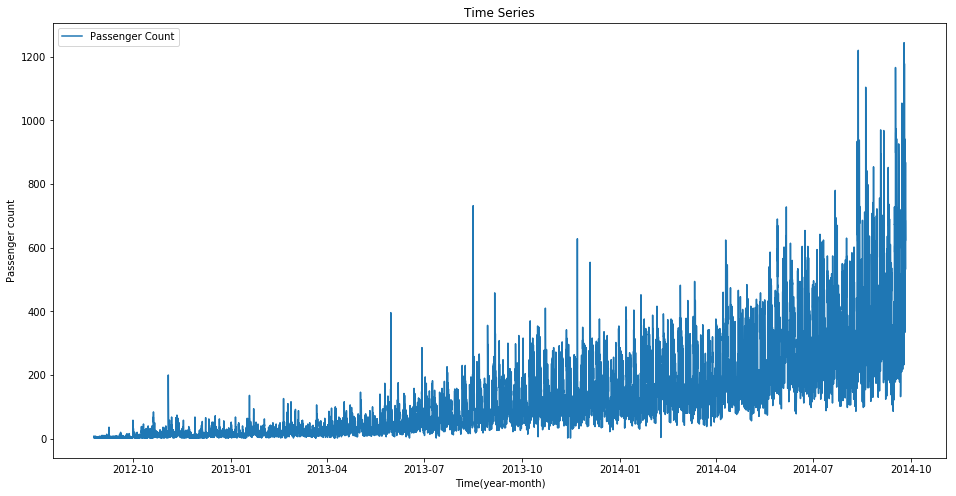

In [13]:
train.index = train['Datetime'] 
df=train.drop('ID',1)           
ts = df['Count']
plt.figure(figsize=(16,8))
plt.plot(ts, label='Passenger Count')
plt.title('Time Series')
plt.xlabel("Time(year-month)")
plt.ylabel("Passenger count")
plt.legend(loc='best')

**We can see that there is an increasing trend in the series**

**EDA**

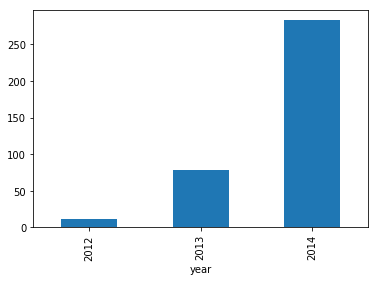

In [14]:
train.groupby('year')['Count'].mean().plot.bar()

*With time traffic is increasing exponentially*

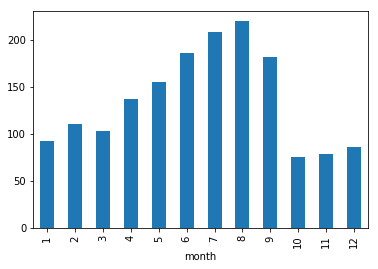

In [15]:
train.groupby('month')['Count'].mean().plot.bar()

*Mean of passenger count decreases in last 3 months* 

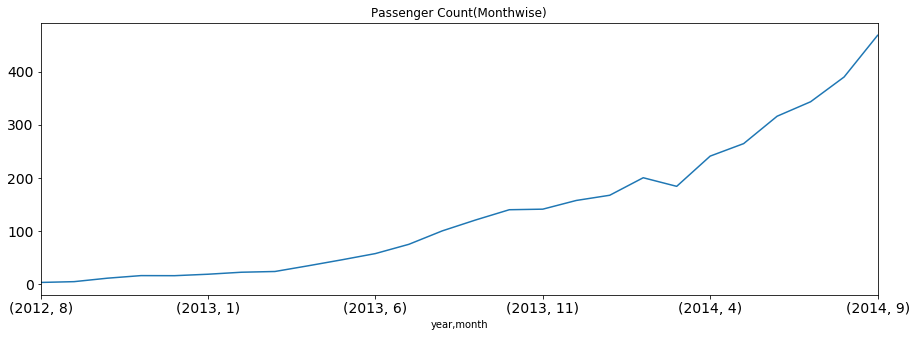

In [16]:
temp=train.groupby(['year', 'month'])['Count'].mean()
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

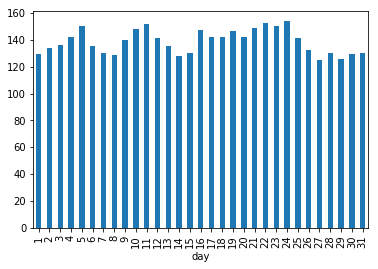

In [17]:
train.groupby('day')['Count'].mean().plot.bar()

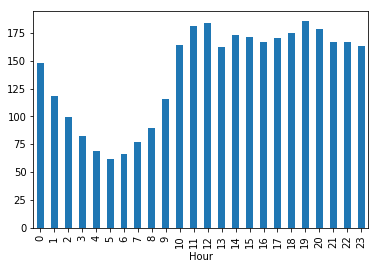

In [18]:
train.groupby('Hour')['Count'].mean().plot.bar()

*Traffic decreases after 12a.m. and increases again from 10p.m.*

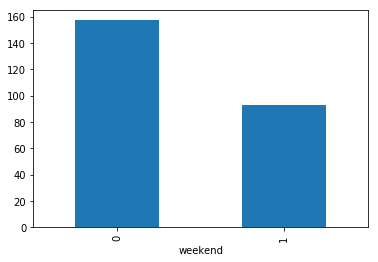

In [19]:
train.groupby('weekend')['Count'].mean().plot.bar()

*clearly on weekends traffic is less*

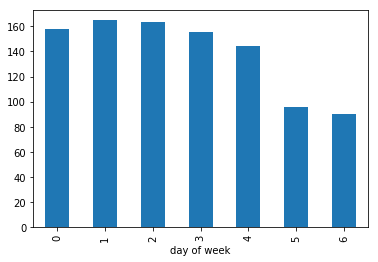

In [20]:
train.groupby('day of week')['Count'].mean().plot.bar()

In [21]:
# Dropping ID
train=train.drop('ID',1)

In [22]:
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp

In [23]:
#hourly time series
hourly = train.resample('H').mean()

#converting to daily mean
daily = train.resample('D').mean()

#converting to weekly mean
weekly = train.resample('W').mean()

#converting to monthly mean
monthly = train.resample('M').mean()

*Plotting hourly, daily, weekly and monthly time series*

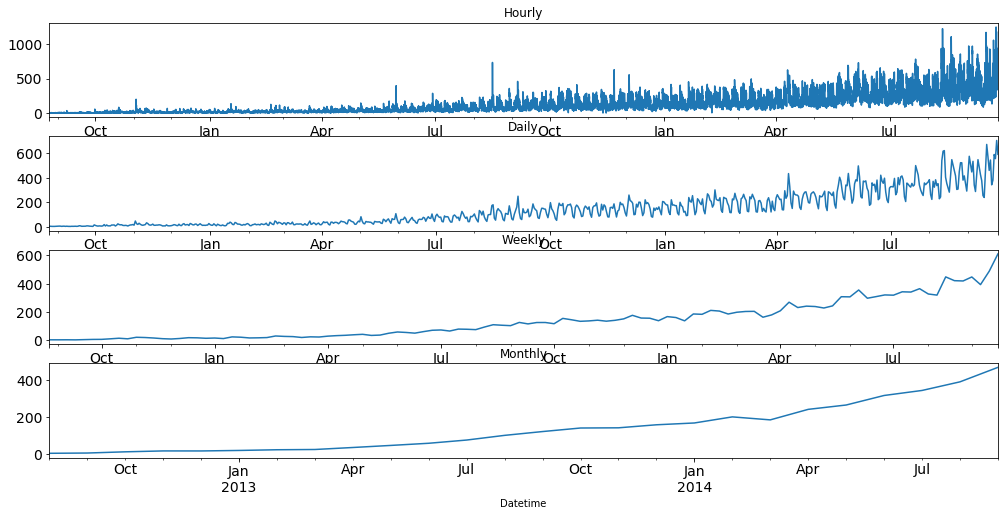

In [24]:
fig, axs = plt.subplots(4,1)

hourly.Count.plot(figsize=(17,8), title= 'Hourly', fontsize=14, ax=axs[0])
daily.Count.plot(figsize=(17,8), title= 'Daily', fontsize=14, ax=axs[1])
weekly.Count.plot(figsize=(17,8), title= 'Weekly', fontsize=14, ax=axs[2])
monthly.Count.plot(figsize=(17,8), title= 'Monthly', fontsize=14, ax=axs[3])

plt.show()

*Monthly time series has less noise in comparison to hourly time series*

*We will work on daily time series*

In [25]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp
train = train.resample('D').mean()

In [26]:
# Splitting training and validation data
Train=train['2012-08-25':'2014-06-24']
valid=train['2014-06-25':'2014-09-25']

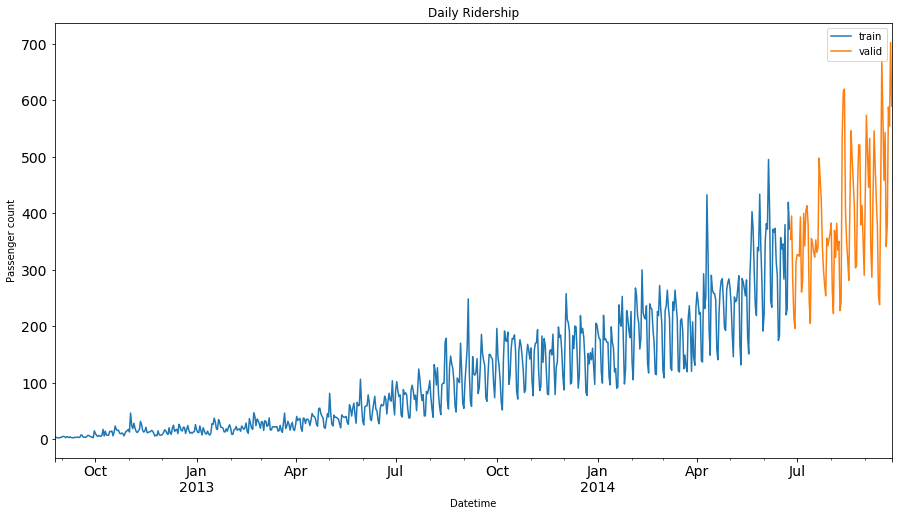

In [27]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='valid')
plt.xlabel("Datetime")
plt.ylabel("Passenger count")
plt.legend(loc='best')
plt.show()

# Modeling

**Naive Approach**

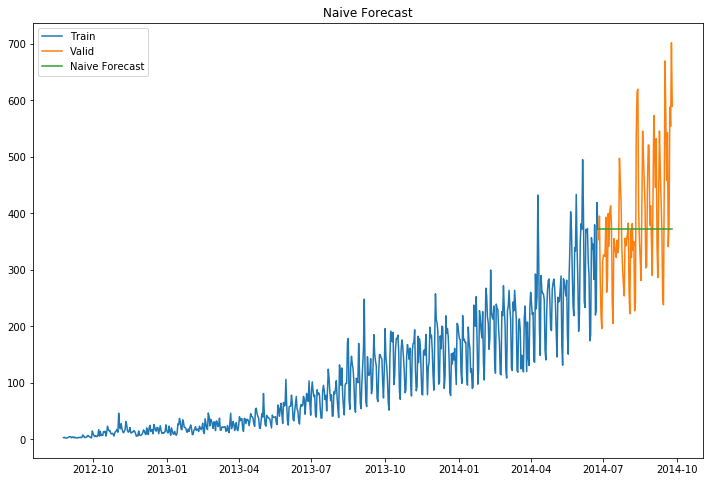

In [28]:
dd= np.asarray(Train.Count)
y_hat = valid.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(Train.index, Train['Count'], label='Train')
plt.plot(valid.index,valid['Count'], label='Valid')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

In [29]:
#checking accuracy with Naive Approach
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(valid.Count, y_hat.naive))
print(rms)

111.79050467496724


**Moving Average**

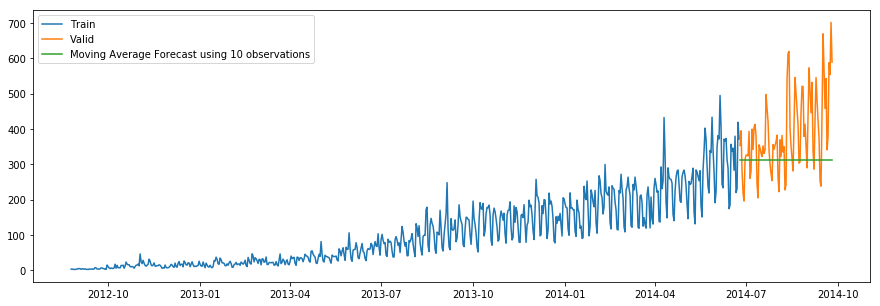

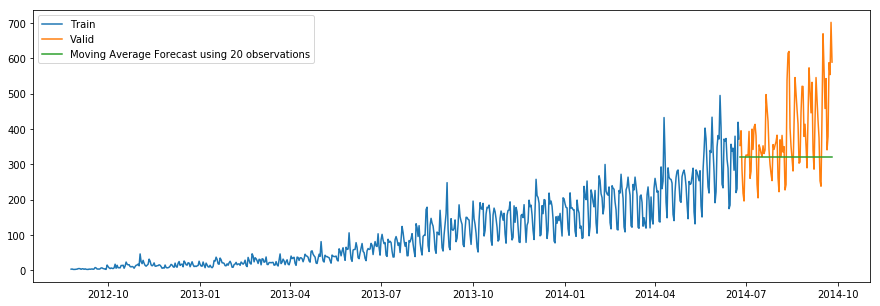

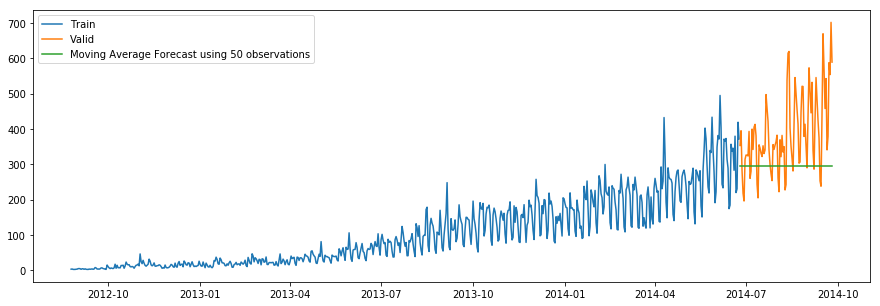

In [30]:
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(10).mean().iloc[-1] # moving average of last 10 observations.
plt.figure(figsize=(15,5)) 
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 10 observations')
plt.legend(loc='best')
plt.show()
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(20).mean().iloc[-1] # moving average of last 20 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 20 observations')
plt.legend(loc='best')
plt.show()
y_hat_avg = valid.copy()
y_hat_avg['moving_avg_forecast'] = Train['Count'].rolling(50).mean().iloc[-1] # moving average of last 50 observations.
plt.figure(figsize=(15,5))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast using 50 observations')
plt.legend(loc='best')
plt.show()

**We can see that the predictions are getting weaker as we increase the number of observations.**

In [31]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.moving_avg_forecast))
print(rms)# Error is even more than Naive Approach

144.19175679986802


**Simple Exponential Smoothing**

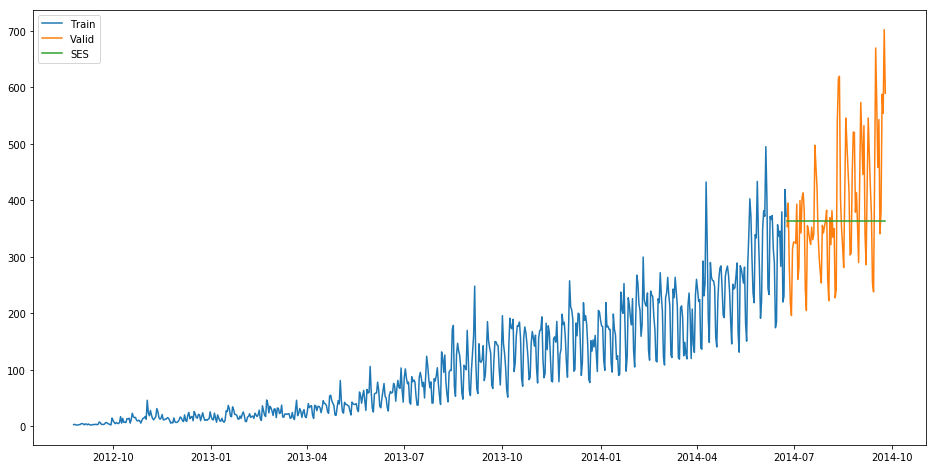

In [32]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = valid.copy()
fit2 = SimpleExpSmoothing(np.asarray(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

In [33]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SES))
print(rms)

113.43708111884514


**Decomposing the timeseries**

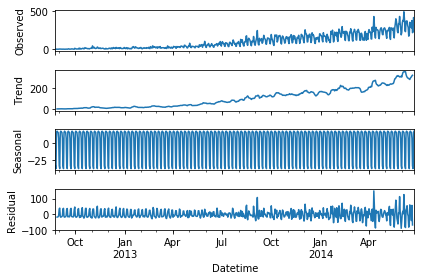

In [34]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

*We can see there is an increasing trend in the series*

**Holt’s Linear Trend Model**

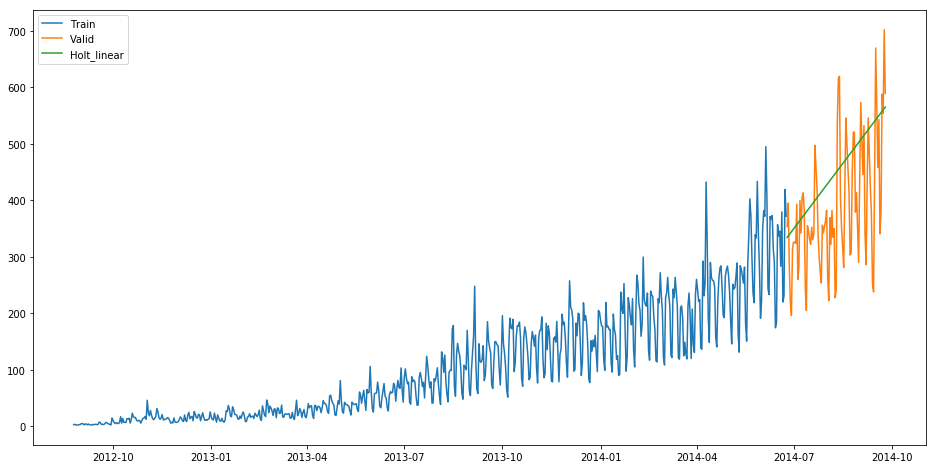

In [35]:
y_hat_avg = valid.copy()

fit1 = Holt(np.asarray(Train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(valid))

plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

In [36]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_linear))
print(rms)

112.94278345314041


In [37]:
submission=pd.read_csv("C:\\Users\\aayus\\Downloads\\Sample_Submission_QChS6c3.csv")

In [38]:
predict=fit1.forecast(len(test))

In [39]:
test['prediction']=predict

In [40]:
# Calculating the hourly ratio of count
train_original['ratio']=train_original['Count']/train_original['Count'].sum()
# Grouping the hourly ratio
temp=train_original.groupby(['Hour'])['ratio'].sum()
# Groupby to csv format
pd.DataFrame(temp, columns=['Hour','ratio']).to_csv('GROUPby.csv')
temp2=pd.read_csv("GROUPby.csv")
temp2=temp2.drop('Hour.1',1)
# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

In [41]:
# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

In [42]:
# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24
prediction['ID']=prediction['ID_y']

In [43]:
submission=prediction.drop(['ID_x', 'day', 'ID_y','prediction','Hour', 'ratio'],axis=1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt linear.csv')

**Holt winter’s model**

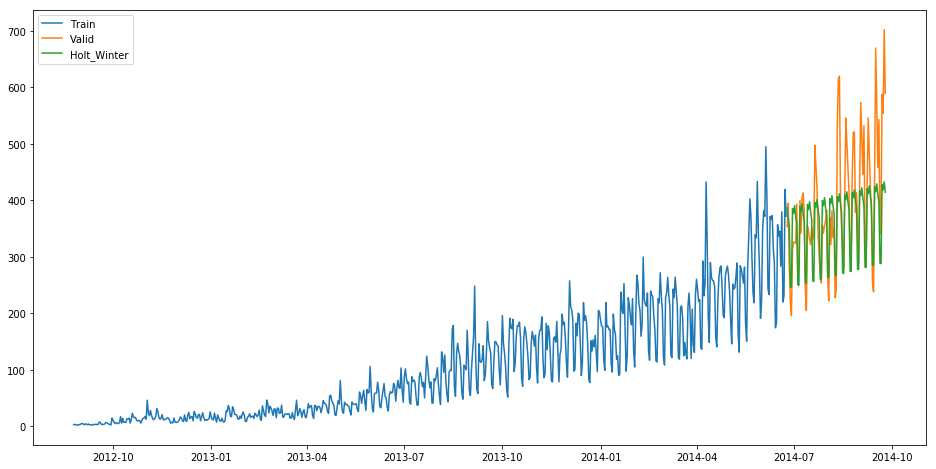

In [44]:
y_hat_avg = valid.copy()
fit1 = ExponentialSmoothing(np.asarray(Train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(valid))
plt.figure(figsize=(16,8))
plt.plot( Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

In [45]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.Holt_Winter))
print(rms)

82.37791846554043


*We can see that the rmse v`alue has reduced a lot from Holt winter’s model*

*Forecasting for test data*

In [46]:
predict=fit1.forecast(len(test))

In [47]:
test['prediction']=predict

In [48]:
# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [49]:
prediction['ID']=prediction['ID_y']
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt winters.csv')

In [50]:
# This model performed well on validation data but had more rmse than holts linear trend model for test data

**Checking the stationarity of the series**

In [51]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=24) # 24 hours on each day
    rolstd = pd.rolling_std(timeseries, window=24)
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [52]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

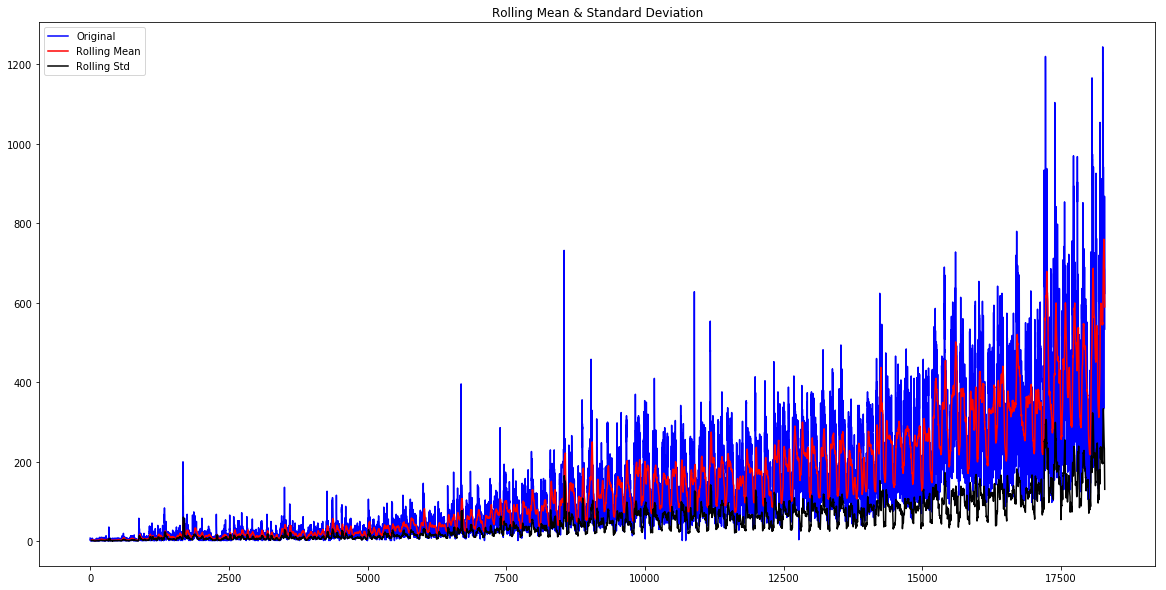

Results of Dickey-Fuller Test:
Test Statistic                    -4.456561
p-value                            0.000235
#Lags Used                        45.000000
Number of Observations Used    18242.000000
Critical Value (1%)               -3.430709
Critical Value (5%)               -2.861698
Critical Value (10%)              -2.566854
dtype: float64


In [53]:
test_stationarity(train_original['Count'])

**Removing Trend**

In [54]:
Train_log = np.log(Train['Count'])
valid_log = np.log(valid['Count'])

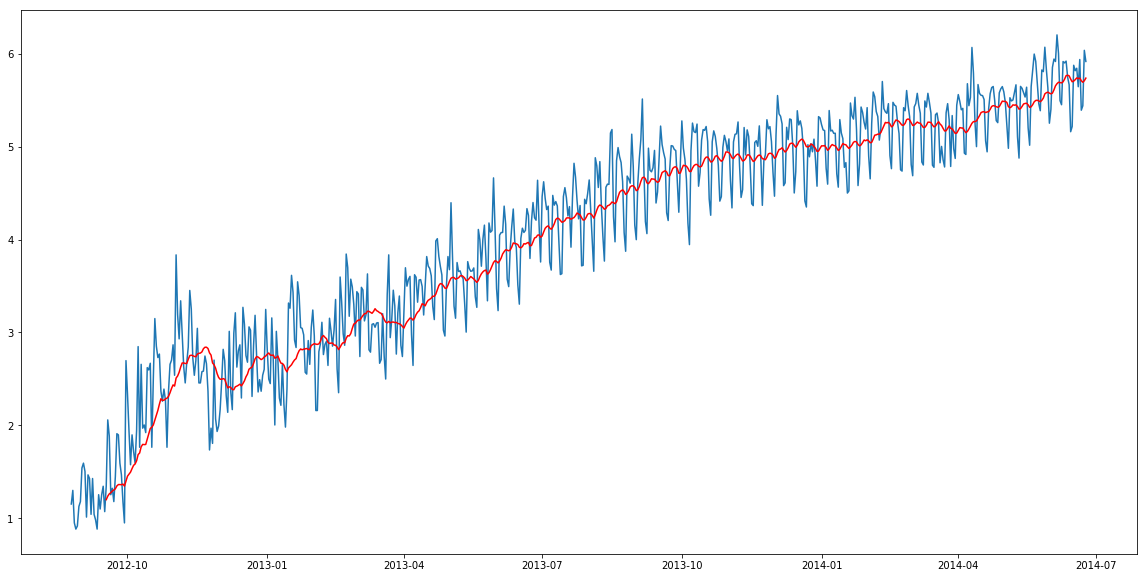

In [55]:
moving_avg = pd.rolling_mean(Train_log, 24)
plt.plot(Train_log)
plt.plot(moving_avg, color = 'red')
plt.show()

In [56]:
train_log_moving_avg_diff = Train_log - moving_avg

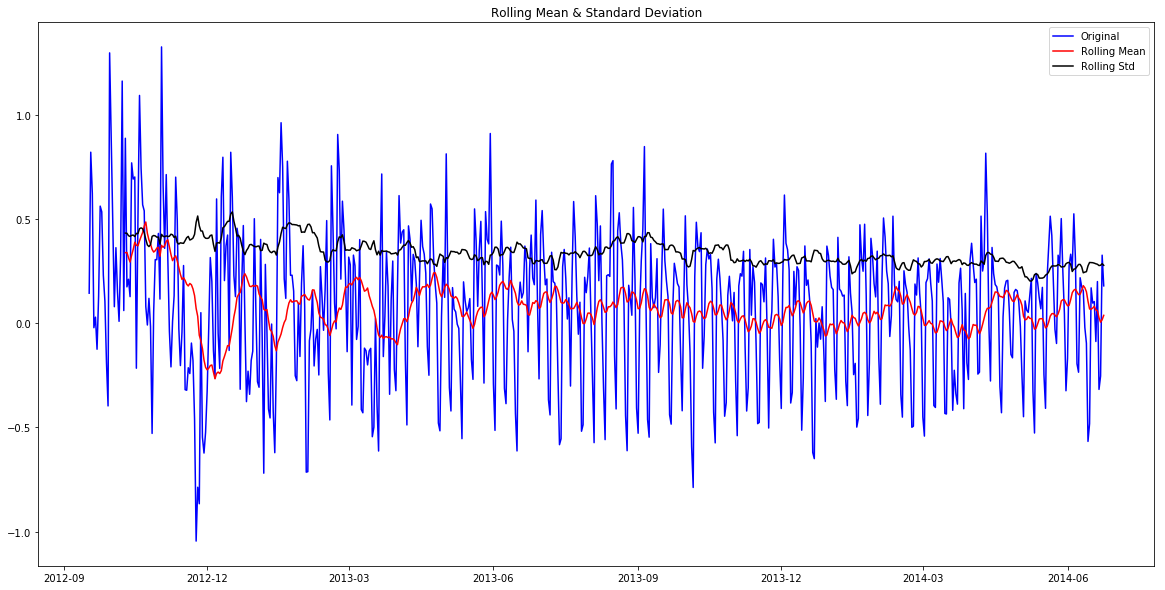

Results of Dickey-Fuller Test:
Test Statistic                -5.861646e+00
p-value                        3.399422e-07
#Lags Used                     2.000000e+01
Number of Observations Used    6.250000e+02
Critical Value (1%)           -3.440856e+00
Critical Value (5%)           -2.866175e+00
Critical Value (10%)          -2.569239e+00
dtype: float64


In [57]:
train_log_moving_avg_diff.dropna(inplace = True)
test_stationarity(train_log_moving_avg_diff)

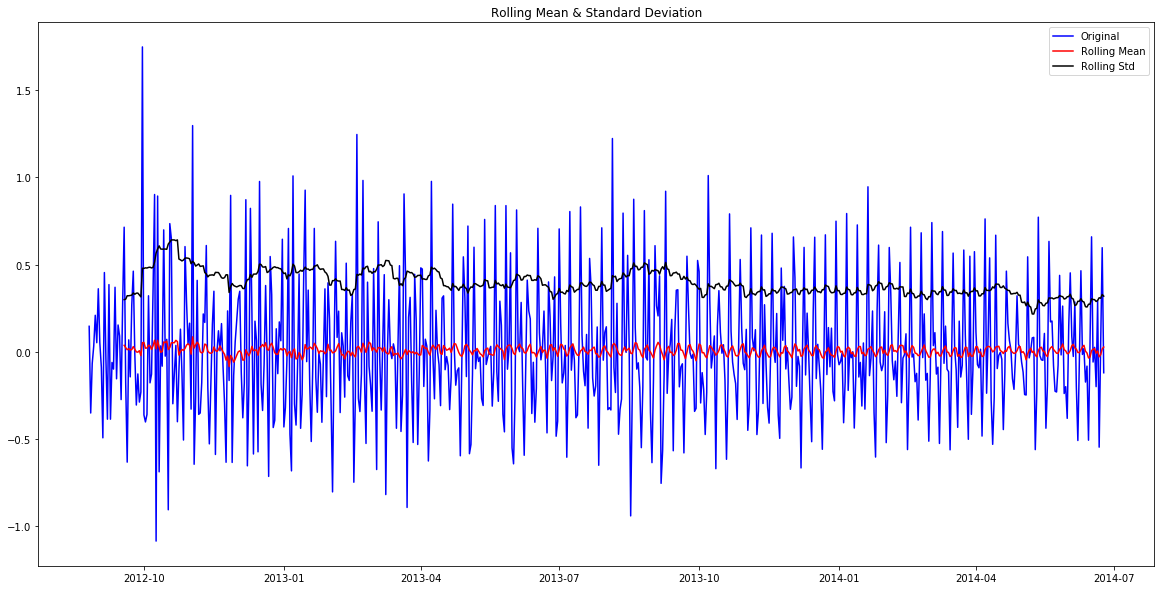

Results of Dickey-Fuller Test:
Test Statistic                -8.237568e+00
p-value                        5.834049e-13
#Lags Used                     1.900000e+01
Number of Observations Used    6.480000e+02
Critical Value (1%)           -3.440482e+00
Critical Value (5%)           -2.866011e+00
Critical Value (10%)          -2.569151e+00
dtype: float64


In [58]:
train_log_diff = Train_log - Train_log.shift(1)
test_stationarity(train_log_diff.dropna())

**Removing Seasonality**

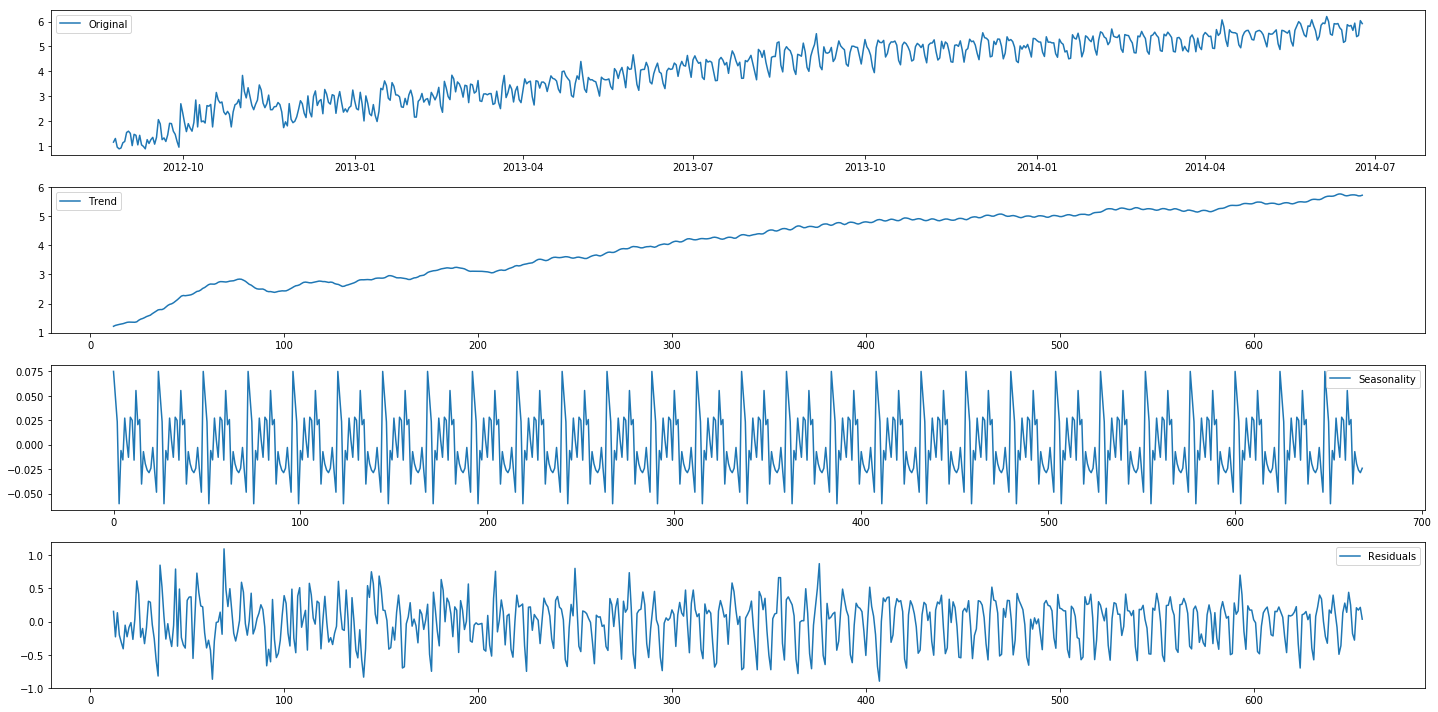

In [59]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(pd.DataFrame(Train_log).Count.values, freq = 24)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(Train_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

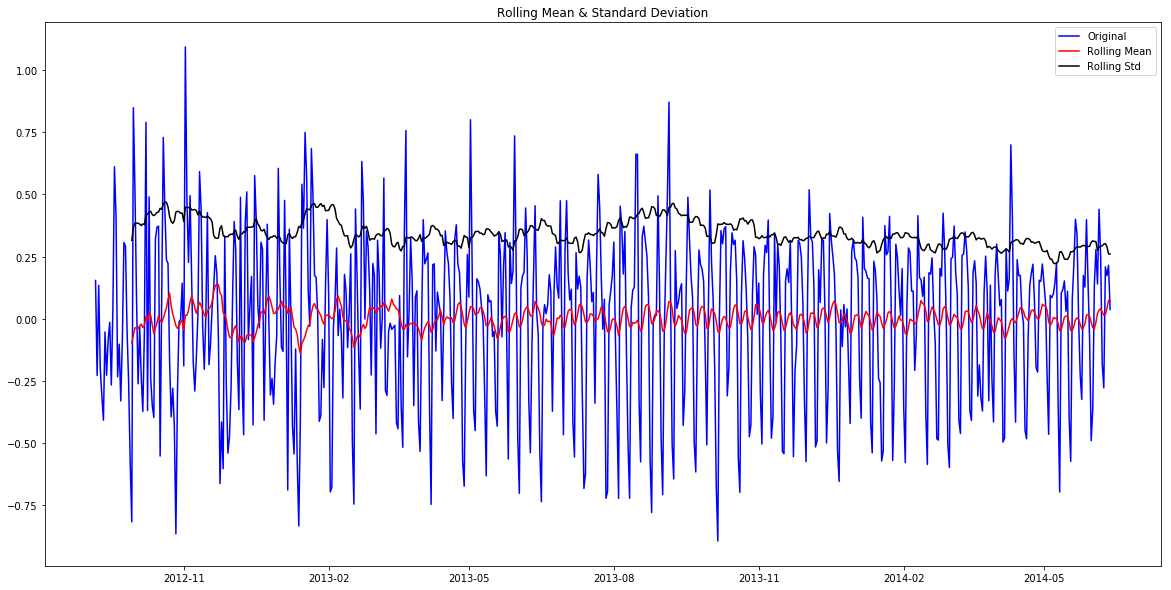

Results of Dickey-Fuller Test:
Test Statistic                -7.822096e+00
p-value                        6.628321e-12
#Lags Used                     2.000000e+01
Number of Observations Used    6.240000e+02
Critical Value (1%)           -3.440873e+00
Critical Value (5%)           -2.866183e+00
Critical Value (10%)          -2.569243e+00
dtype: float64


In [60]:
train_log_decompose = pd.DataFrame(residual)
train_log_decompose['date'] = Train_log.index
train_log_decompose.set_index('date', inplace = True)
train_log_decompose.dropna(inplace=True)
test_stationarity(train_log_decompose[0])

**Forecasting using Arima**

In [61]:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=25)
lag_pacf = pacf(train_log_diff.dropna(), nlags=25, method='ols')

** Plotting ACF and PACF plot**

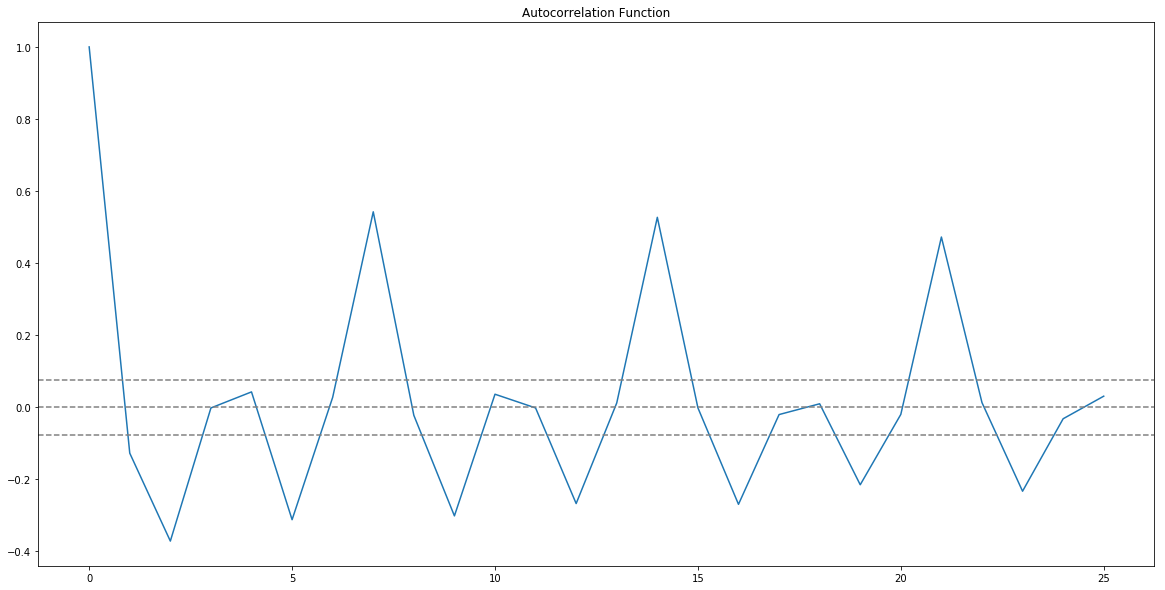

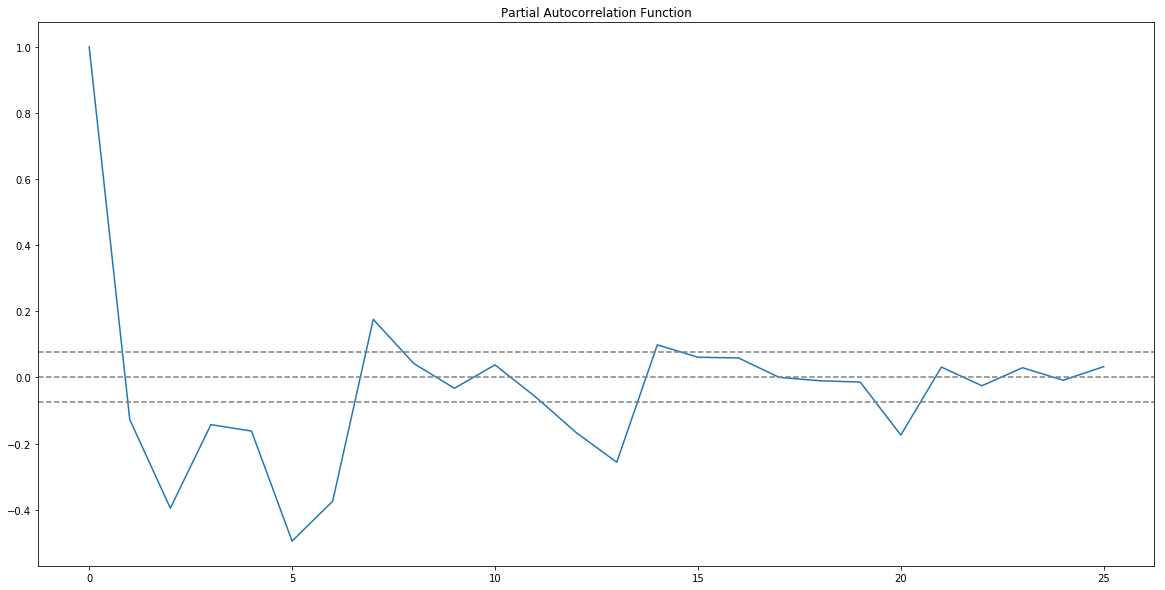

In [62]:
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
plt.show()
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.show()

*p value is the lag value where the PACF chart crosses the upper confidence interval for the first time.
q value is the lag value where the ACF chart crosses the upper confidence interval for the first time.
so p=1,q=1*

**AR model**

In [64]:
from statsmodels.tsa.arima_model import ARIMA

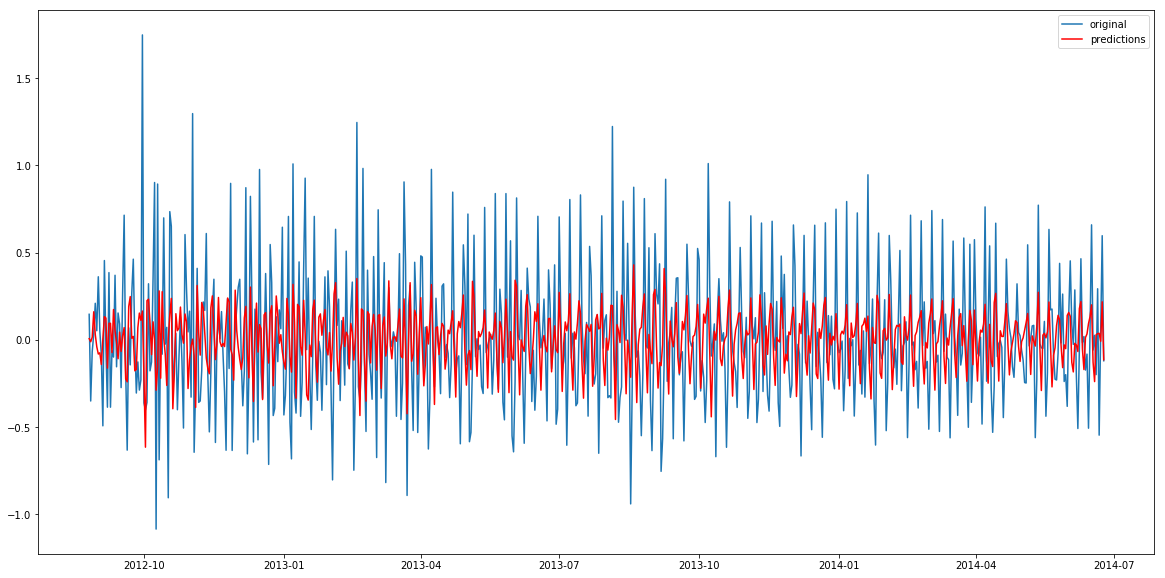

In [65]:
model = ARIMA(Train_log, order=(2, 1, 0))  # here the q value is zero since it is just the AR model
results_AR = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_AR.fittedvalues, color='red', label='predictions')
plt.legend(loc='best')
plt.show()

In [66]:
AR_predict=results_AR.predict(start="2014-06-25", end="2014-09-25")
AR_predict=AR_predict.cumsum().shift().fillna(0)
AR_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
AR_predict1=AR_predict1.add(AR_predict,fill_value=0)
AR_predict = np.exp(AR_predict1)

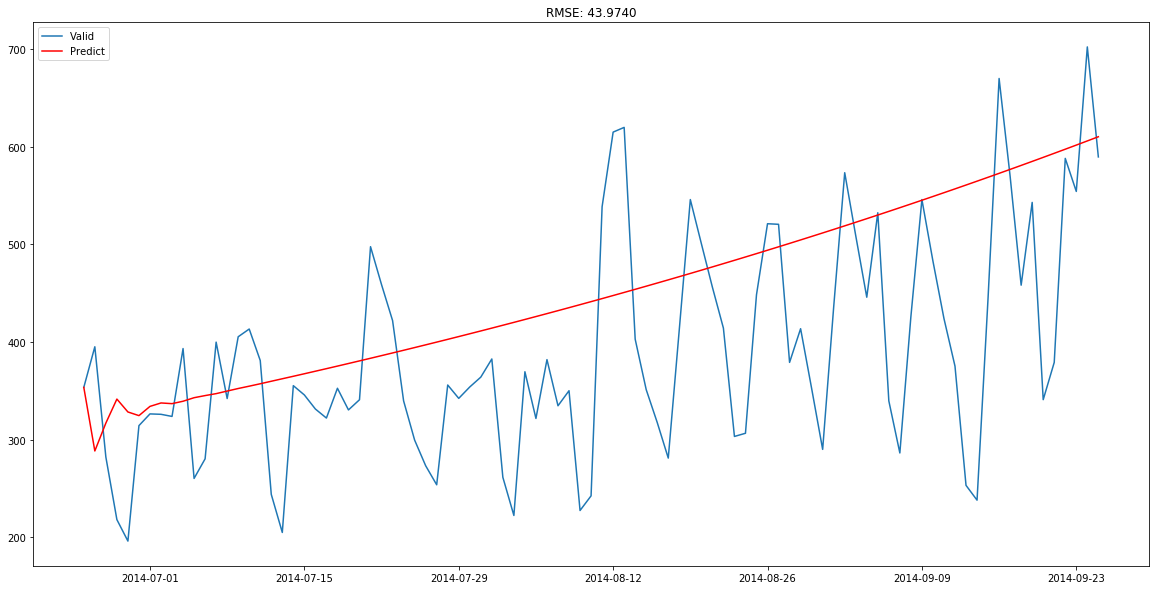

In [67]:
plt.plot(valid['Count'], label = "Valid")
plt.plot(AR_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(AR_predict, valid['Count']))/valid.shape[0]))
plt.show()

*Red line shows the prediction for the validation set*

**MA model**

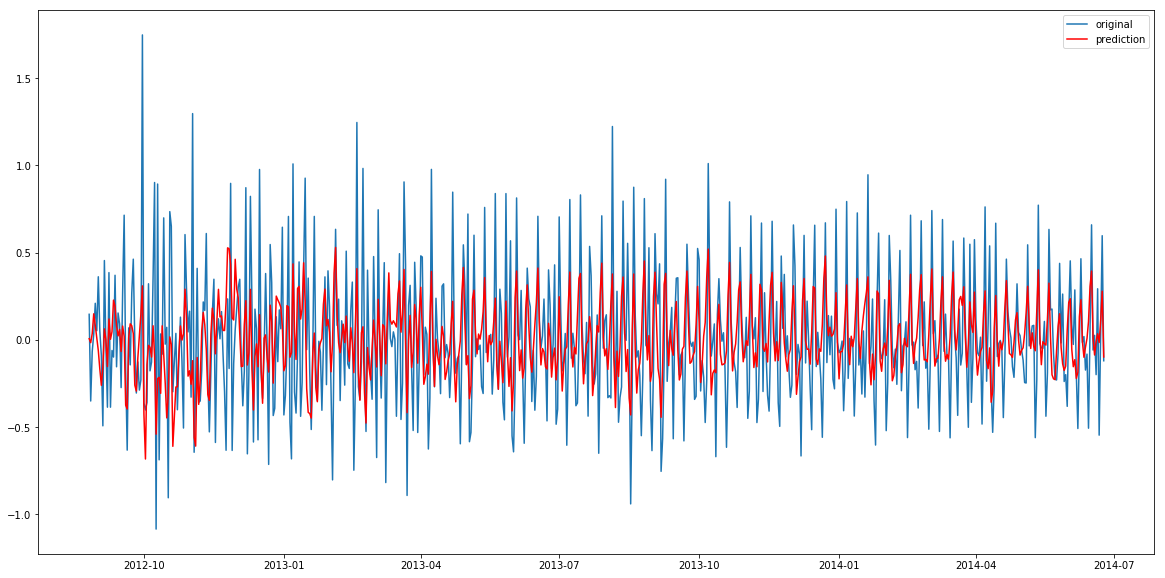

In [70]:
model = ARIMA(Train_log, order=(0, 1, 2))  # here the p value is zero since it is just the MA model
results_MA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(), label='original')
plt.plot(results_MA.fittedvalues, color='red', label='prediction')
plt.legend(loc='best')
plt.show()

In [71]:
MA_predict=results_MA.predict(start="2014-06-25", end="2014-09-25")
MA_predict=MA_predict.cumsum().shift().fillna(0)
MA_predict1=pd.Series(np.ones(valid.shape[0]) * np.log(valid['Count'])[0], index = valid.index)
MA_predict1=MA_predict1.add(MA_predict,fill_value=0)
MA_predict = np.exp(MA_predict1)

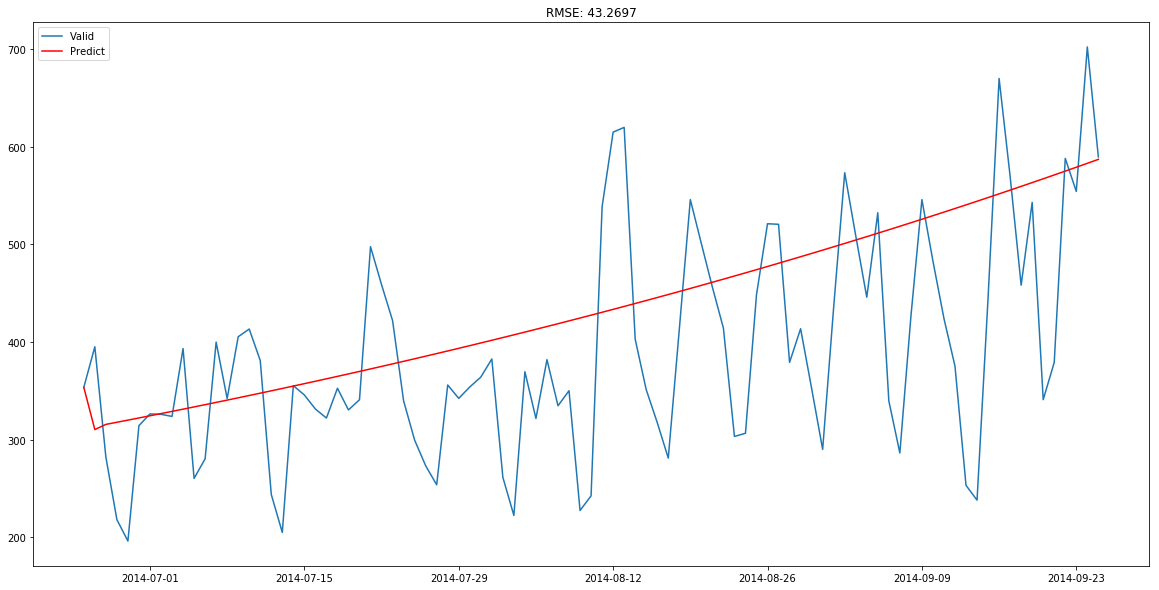

In [72]:
plt.plot(valid['Count'], label = "Valid")
plt.plot(MA_predict, color = 'red', label = "Predict")
plt.legend(loc= 'best')
plt.title('RMSE: %.4f'% (np.sqrt(np.dot(MA_predict, valid['Count']))/valid.shape[0]))
plt.show()

**Combining AR AND MA model**

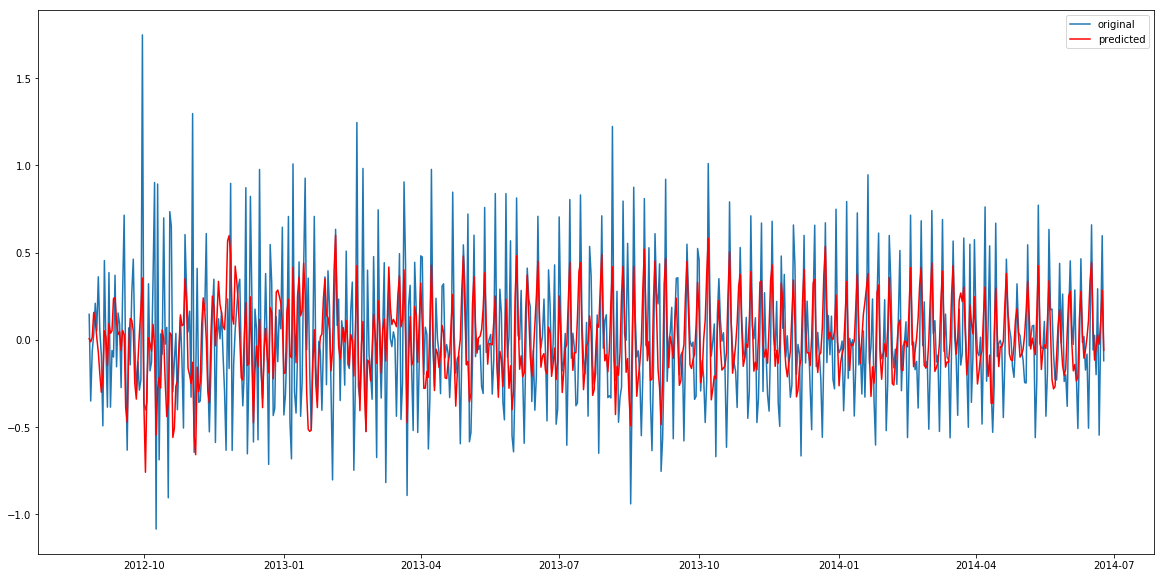

In [74]:
model = ARIMA(Train_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(train_log_diff.dropna(),  label='original')
plt.plot(results_ARIMA.fittedvalues, color='red', label='predicted')
plt.legend(loc='best')
plt.show()

**Changing the scale of the model to the original scale**

In [75]:
def check_prediction_diff(predict_diff, given_set):
    predict_diff= predict_diff.cumsum().shift().fillna(0)
    predict_base = pd.Series(np.ones(given_set.shape[0]) * np.log(given_set['Count'])[0], index = given_set.index)
    predict_log = predict_base.add(predict_diff,fill_value=0)
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [76]:
def check_prediction_log(predict_log, given_set):
    predict = np.exp(predict_log)
    
    plt.plot(given_set['Count'], label = "Given set")
    plt.plot(predict, color = 'red', label = "Predict")
    plt.legend(loc= 'best')
    plt.title('RMSE: %.4f'% (np.sqrt(np.dot(predict, given_set['Count']))/given_set.shape[0]))
    plt.show()

In [79]:
# predicting values for validation set

In [77]:
ARIMA_predict_diff=results_ARIMA.predict(start="2014-06-25", end="2014-09-25")

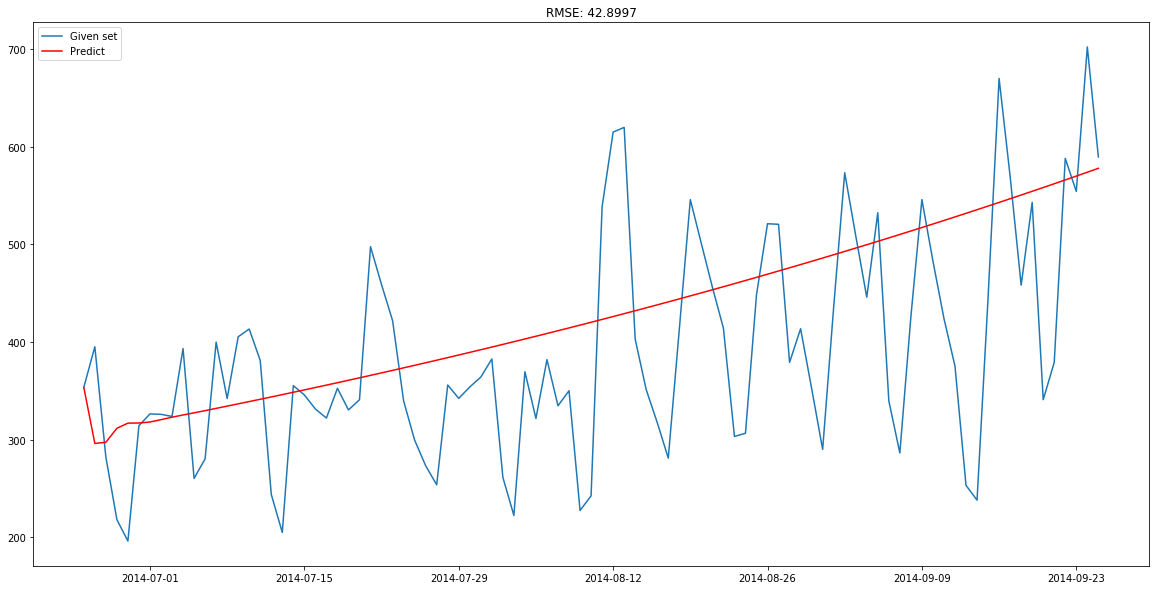

In [78]:
check_prediction_diff(ARIMA_predict_diff, valid)

**SARIMAX model on daily time series**

In [80]:
import statsmodels.api as sm

C:\Users\aayus\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


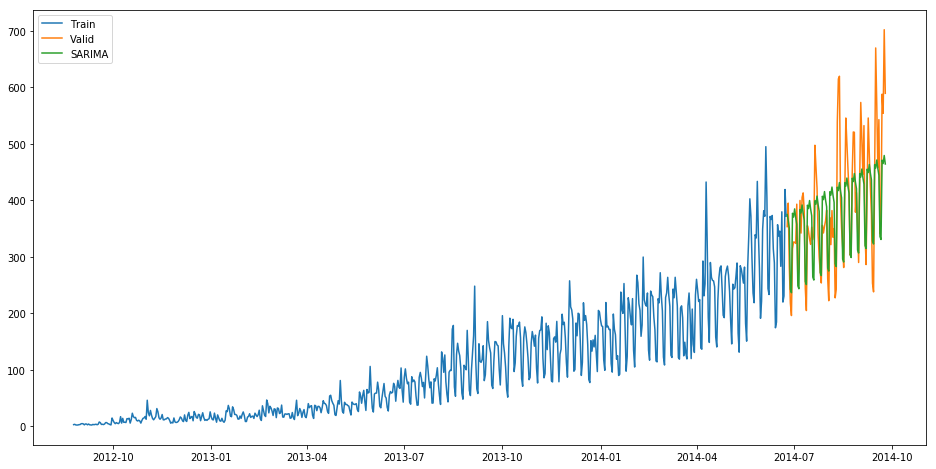

In [81]:
y_hat_avg = valid.copy()
fit1 = sm.tsa.statespace.SARIMAX(Train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2014-6-25", end="2014-9-25", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( Train['Count'], label='Train')
plt.plot(valid['Count'], label='Valid')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

In [82]:
#checking the rmse value for the validation part.

In [83]:
rms = sqrt(mean_squared_error(valid.Count, y_hat_avg.SARIMA))
print(rms)

70.08532967182593


In [84]:
predict=fit1.predict(start="2014-9-26", end="2015-4-26", dynamic=True)

C:\Users\aayus\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:1740: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  ' effect.', ValueWarning)


In [86]:
test['prediction']=predict

In [87]:
# Merge Test and test_original on day, month and year
merge=pd.merge(test, test_original, on=('day','month', 'year'), how='left')
merge['Hour']=merge['Hour_y']
merge=merge.drop(['year', 'month', 'Datetime','Hour_x','Hour_y'], axis=1)

# Predicting by merging merge and temp2
prediction=pd.merge(merge, temp2, on='Hour', how='left')

# Converting the ratio to the original scale
prediction['Count']=prediction['prediction']*prediction['ratio']*24

In [88]:
prediction['ID']=prediction['ID_y']
submission=prediction.drop(['day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)

# Converting the final submission to csv format
pd.DataFrame(submission, columns=['ID','Count']).to_csv('SARIMAX.csv')